In [1]:
import numpy
import analysis
import lsst.daf.persistence

In [2]:
#butler = lsst.daf.persistence.Butler("/lustre/Subaru/SSP/rerun/yasuda/SSP3.8.5_20150725/")
butler = lsst.daf.persistence.Butler("/tigress/HSC/HSC/rerun/jbosch/HSC-1313/fixed/")

In [3]:
#objIds = [37480444425426832,37480727893263379,37480440130461503,37480444425423299,
#          37480581864381920,37485117349844128]
#splits = analysis.splitCoaddId(objIds, hasFilter=False)
#dataIDs = [dict(tract=int(d[0]), patch=str(d[1]))
#           for d in set((splits["tract"][i], splits["patch"][i]) for i in range(len(objIds)))]
dataIDs = [dict(tract=0, patch="4,4")]

In [4]:
loader = analysis.CatalogLoader(butler, filters="i", forced=False)

In [5]:
catalog = loader.read(dataIDs[:1], progress=True)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [6]:
#r = [catalog.find(i) for i in objIds]

In [7]:
def recordStats(record, filters="griz"):
    meas = lambda b, suffix: record.get("meas.{0}.{1}".format(b, suffix))
    forced = lambda b, suffix: record.get("forced.{0}.{1}".format(b, suffix))
    detR = lambda b, suffix: meas(b, suffix).getDeterminantRadius()
    trR = lambda b, suffix: meas(b, suffix).getTraceRadius()
    lines = [
        " | ".join("{0:>21s}".format(b) if not record.get("merge.measurement.{0}".format(b))
                   else "{0:>20s}*".format(b)
                   for b in filters),
        " | ".join("{0:>10s} {1:>10s}".format("meas", "forced") for b in filters),
        "-+-".join("-"*21 for b in filters),
        " | ".join("{0:5.2f}±{1:4.2f} {2:5.2f}±{3:4.2f}".format(
                      meas(b, "cmodel.mag"), meas(b, "cmodel.mag.err"),
                      forced(b, "cmodel.mag"), forced(b, "cmodel.mag.err")
                   )
                  for b in filters) + "  CModel mag",
        " | ".join("{0:5.2f}±{1:4.2f} {2:5.2f}±{3:4.2f}".format(
                      meas(b, "mag.kron"), meas(b, "mag.kron.err"),
                      forced(b, "mag.kron"), forced(b, "mag.kron.err")
                   )
                  for b in filters) + " Kron mag",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "cmodel.flux")/meas(b, "cmodel.flux.err"),
                                                forced(b, "cmodel.flux")/forced(b, "cmodel.flux.err"))
                  for b in filters) + " CModel SNR",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "flux.kron")/meas(b, "flux.kron.err"),
                                                forced(b, "flux.kron")/forced(b, "flux.kron.err"))
                  for b in filters) + " Kron SNR",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "cmodel.fracDev"), forced(b, "cmodel.fracDev"))
                  for b in filters) + " CModel fracDev",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "cmodel.initial.ellipse"), detR(b, "cmodel.initial.ellipse"))
                  for b in filters) + " CModel initial radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "cmodel.exp.ellipse"), detR(b, "cmodel.exp.ellipse"))
                  for b in filters) + " CModel exp radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "cmodel.dev.ellipse"), detR(b, "cmodel.dev.ellipse"))
                  for b in filters) + " CModel dev radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "shape.sdss"), detR(b, "shape.sdss"))
                  for b in filters) + " SDSS shape radius",
        " | ".join(" tr={0:6.2f}  det={1:5.2f}".format(trR(b, "shape.hsm.moments"), detR(b, "shape.hsm.moments"))
                  for b in filters) + " HSM shape radius",
        " | ".join("{0:10.2f} {1:10.2f}".format(meas(b, "flux.kron.radius"), forced(b, "flux.kron.radius"))
                  for b in filters) + " Kron radius (det)",
    ]
    print "\n".join(lines)
#recordStats(r[0])

In [8]:
import matplotlib
%matplotlib inline

In [9]:
flags = ["i.flags.pixel.edge",
         "i.flags.pixel.saturated.center",
         "i.flags.pixel.cr.center",
         "i.flags.pixel.bad",
         "meas.i.cmodel.flux.flags",
         "meas.i.centroid.sdss.flags",]
mask = numpy.logical_and(
    catalog.get("detect.is-primary"),
    numpy.logical_not(numpy.logical_or.reduce([catalog.get(s) for s in flags]))
    )

In [10]:
def col(field):
    return catalog.get("meas.i.%s" % field)[mask]
def snr(flux):
    return col(flux)/col(flux+".err")

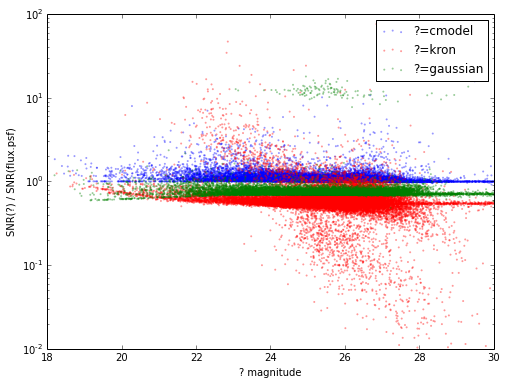

In [11]:
fig = matplotlib.pyplot.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
scatterKwds = dict(s=4, linewidth=0, alpha=0.4)
ax.scatter(col("cmodel.mag"),
           snr("cmodel.flux")/snr("flux.psf"),
           c='blue', label="?=cmodel",
           **scatterKwds)
ax.scatter(col("mag.kron"),
           snr("flux.kron")/snr("flux.psf"),
           c='red', label="?=kron",
            **scatterKwds)
ax.scatter(col("mag.gaussian"),
           snr("flux.gaussian")/snr("flux.psf"),
           c='green', label="?=gaussian",
            **scatterKwds)
ax.semilogy()
ax.legend()
ax.set_xlabel("? magnitude")
ax.set_ylabel("SNR(?) / SNR(flux.psf)")
ax.set_xlim(18.0, 30.0)
ax.set_ylim(0.01, 100.0)
fig.savefig("SNRvsMag.png")

In [148]:
import scipy.optimize

def computeFluxVariance(beta, prefix):
    pxx = col("shape.sdss.psf.xx")
    pyy = col("shape.sdss.psf.yy")
    pxy = col("shape.sdss.psf.xy")
    if prefix == "cmodel":
        dxx = col("%s.dev.ellipse.xx" % prefix)
        dyy = col("%s.dev.ellipse.yy" % prefix)
        dxy = col("%s.dev.ellipse.xy" % prefix)
        exx = col("%s.exp.ellipse.xx" % prefix)
        eyy = col("%s.exp.ellipse.yy" % prefix)
        exy = col("%s.exp.ellipse.xy" % prefix)
        fracDev = col("%s.fracDev" % prefix)
        qxx = fracDev*dxx + (1.0 - fracDev)*exx
        qyy = fracDev*dyy + (1.0 - fracDev)*eyy
        qxy = fracDev*dxy + (1.0 - fracDev)*exy
    else:
        qxx = col("%s.ellipse.xx" % prefix)
        qyy = col("%s.ellipse.yy" % prefix)
        qxy = col("%s.ellipse.xy" % prefix)
    mxx = pxx + beta*qxx
    myy = pyy + beta*qyy
    mxy = pxy + beta*qxy
    psfFluxVar = col("flux.psf.err")**2
    return (((mxx*myy - mxy**2)/(pxx*pyy - pxy**2))**0.5)*psfFluxVar

def optfunc(parameters, prefix):
    beta = parameters[0]
    data = numpy.abs(col("%s.flux.err" % prefix))
    model = computeFluxVariance(beta, prefix)**0.5
    return numpy.log(model/data)

In [149]:
def fitWorkaround(prefix):
    (beta,), status = scipy.optimize.leastsq(optfunc, [0.63], (prefix,))
    print beta
    fig = matplotlib.pyplot.figure(figsize=(8,6))
    ax1 = fig.add_subplot(1, 2, 1)
    scatterKwds = dict(s=4, linewidth=0, alpha=0.1)
    pred = computeFluxVariance(beta, prefix)**0.5
    y = pred / col("%s.flux.err" % prefix)
    ax1.scatter(col("%s.mag" % prefix), y, **scatterKwds)
    ax1.set_title("%s: beta=%f" % (prefix, beta))
    ax1.set_xlabel("%s magnitude" % prefix)
    ax1.set_ylabel("predicted sigma / true sigma")
    ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
    ax2.hist(y, orientation='horizontal', bins=80, range=(0.80, 1.20), normed=True)
    ax1.set_xlim(18.0, 28.0)
    ax1.set_ylim(0.80, 1.20)
    fig.savefig("PredvsMag-%s.png" % prefix)

0.632567867665


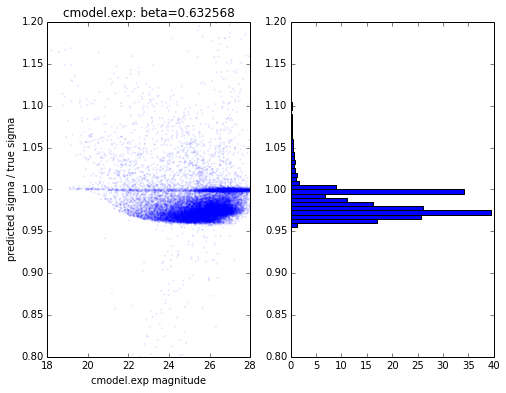

In [150]:
fitWorkaround("cmodel.exp")

0.438678631127


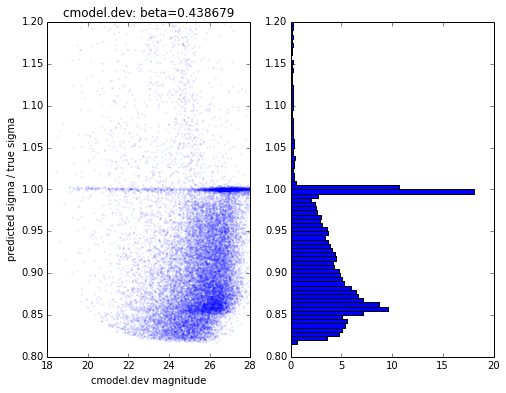

In [151]:
fitWorkaround("cmodel.dev")

0.53163702323


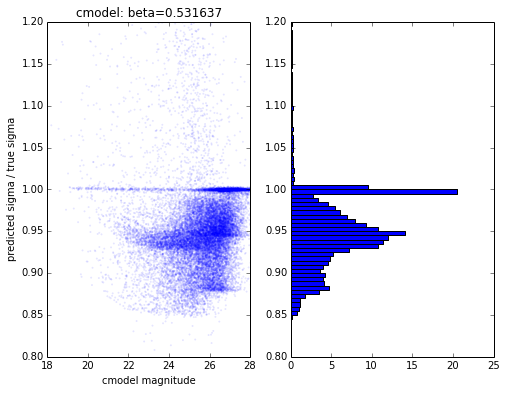

In [152]:
fitWorkaround("cmodel")

In [135]:
catalog.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Coord'](name="coord", doc="position in ra/dec", units="IRCS; radians"), Key<Coord>(offset=8, nElements=2)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="merge.footprint.i", doc="Detection footprint overlapped with a detection from filter i"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="merge.footprint.r", doc="Detection footprint overlapped with a detection from filter r"), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="merge.footprint.z", doc="Detection footprint overlapped with a detection from filter z"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="merge.footprint.y", doc="Detection footprint overlapped with a detection from filter y"), Key['Flag'](offset=32, bit=3)),
    (Field['Flag'](name="merge.footprint.g", doc="Detection footprint overlapped with a detection from filte